<a href="https://colab.research.google.com/github/AnuragSahu/Research_In_Progress/blob/master/myCIFAR10_VGG16_LR_0_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
#Getting the dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#LABELS 0,1,2,3,4,5,6,7,8,9


0it [00:00, ?it/s]

100%|█████████▉| 170303488/170498071 [00:36<00:00, 3304431.25it/s]

Files already downloaded and verified


In [3]:
print(type(trainset))
print(type(trainloader))
print(type(testset))
print(type(testloader))
#converting into an iterable object
trainiter = iter(trainloader)
#print("Number of train samples",len(list(trainiter)))
testiter = iter(testloader)
#print("Number of test samples",len(list(testiter)))
#images, labels = trainiter.next()


<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torchvision.datasets.cifar.CIFAR10'>
<class 'torch.utils.data.dataloader.DataLoader'>


<class 'torch.Tensor'>
torch.Size([64, 3, 32, 32])


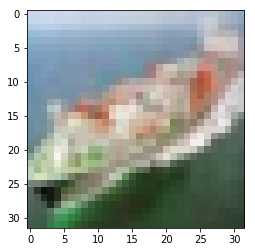

In [4]:
#Analyzing one sample and display one particular image
image, label = trainiter.next()
print(type(image))
print(image.size())

img = image[0,:].numpy();
img=np.transpose(img,(1,2,0))

import matplotlib.pyplot as plt
plt.imshow(img)

In [0]:
NUM_CLASSES = 10


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg['VGG16'])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [0]:
#MAIN CELL

#net= AlexNet() 
net = VGG()

criterion = nn.CrossEntropyLoss()
lr=1e-3
momentum=0.09
nepochs = 20
#optimizer = optim.SGD(net.parameters(), lr, momentum)
optimizer=optim.Adam(net.parameters(), lr)

def correct(groundTruth,output):
  assert groundTruth.size(0) == output.size(0)
  _, indices = torch.max(outputs, 1)
  ch=torch.eq(groundTruth,indices)
  return torch.sum(ch).item()

trainAcc=[];testAcc=[];
trainLoss=[];testLoss=[];

totalTrainSamples=len(trainloader.dataset)
print("Total training samples :", totalTrainSamples)
totalTestSamples=len(testloader.dataset);
print("Total testing samples :", totalTestSamples)


for epoch in range(nepochs):
  
    #TRAINING
    running_loss_train = 0.0
    numCorr_train=0;
    net.train()
    inputs_=None;labels_=None;
    
    for i, data in enumerate(trainloader, 0):
       
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs.size())
        numCorr_train+=correct(labels,outputs)
        
    
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss_train += loss.item()
        #break
    if epoch % 2 == 0:
      print("Epoch", epoch, "Train loss",running_loss_train/totalTrainSamples)
      print("Train Accuracy: ", round((numCorr_train/totalTrainSamples)*100,2),"%" )
            
    
    trainAcc.append((numCorr_train/totalTrainSamples)*100)
    trainLoss.append(running_loss_train/totalTrainSamples)
    
    #TESTING
    running_loss_test = 0.0
    numCorr_test=0;
    #net.train()
    inputs_=None;labels_=None;
    
    for i, data in enumerate(testloader, 0):
       
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        #optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print(outputs.size())
        numCorr_test+=correct(labels,outputs)
        
    
        loss = criterion(outputs, labels)
        #loss.backward()
        #optimizer.step()

        # print statistics
        running_loss_test += loss.item()
        #break
    if epoch % 2 == 0:
      print("Epoch", epoch, "Train loss",running_loss_test/totalTestSamples)
      print("Test Accuracy: ", round((numCorr_test/totalTestSamples)*100,2),"%" )
            
    
    testAcc.append((numCorr_test/totalTestSamples)*100)
    testLoss.append(running_loss_test/totalTestSamples)

Total training samples : 50000
Total testing samples : 10000
Epoch 0 Train loss 0.02349608976840973
Train Accuracy:  42.59 %
Epoch 0 Train loss 0.017541797316074373
Test Accuracy:  59.66 %
Epoch 2 Train loss 0.010964235129356384
Train Accuracy:  75.93 %
Epoch 2 Train loss 0.010653101190924644
Test Accuracy:  77.16 %
Epoch 4 Train loss 0.007337089042365551
Train Accuracy:  84.3 %
Epoch 4 Train loss 0.008718267750740052
Test Accuracy:  81.47 %
Epoch 6 Train loss 0.00501601374104619
Train Accuracy:  89.19 %
Epoch 6 Train loss 0.00877555675059557
Test Accuracy:  82.58 %
Epoch 8 Train loss 0.003408561589196324
Train Accuracy:  92.62 %
Epoch 8 Train loss 0.007889535009115935
Test Accuracy:  84.92 %


In [0]:
  
    #Plots

import matplotlib.pyplot as plt

fig1, ax1=  plt.subplots()
plt.grid()
ax1.plot(trainAcc,marker='o', markerfacecolor='red', markersize=5, color='orange', linewidth=4)
ax1.plot(testAcc,marker='o', markerfacecolor='red', markersize=5, color='blue', linewidth=4)
plt.gca().legend(('Train','Test'))
ax1.set_title("Train V/S Test Accuracy")
ax1.set_xlabel("#Epochs")




fig2, ax2=  plt.subplots()
plt.grid()
ax2.plot(trainLoss,marker='o', markerfacecolor='red', markersize=5, color='orange', linewidth=4,label="Train Loss")
ax2.plot(testLoss,marker='o', markerfacecolor='red', markersize=5, color='blue', linewidth=4,label="Test Loss")
plt.gca().legend(('Train','Test'))
ax2.set_title("Train V/S Test Loss")
ax2.set_xlabel("#Epochs")

fig3, ax3=  plt.subplots()
plt.grid()
ax3.plot(trainLoss,marker='o', markerfacecolor='green', markersize=5, color='yellow', linewidth=4,label="Train Loss")
ax3.set_title("Train Loss")
ax3.set_xlabel("#Epochs")


In [0]:
# upload external file before import
from google.colab import files

torch.save(net.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 44274, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil